# General form regression using DeepLearning

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from symreg.formula import *
from symreg.simplify import *
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


## Normalization

In [3]:
X = np.linspace(0, 10, 1000)
Y = 3 * np.sin(0.5 * X * X) + X - 10

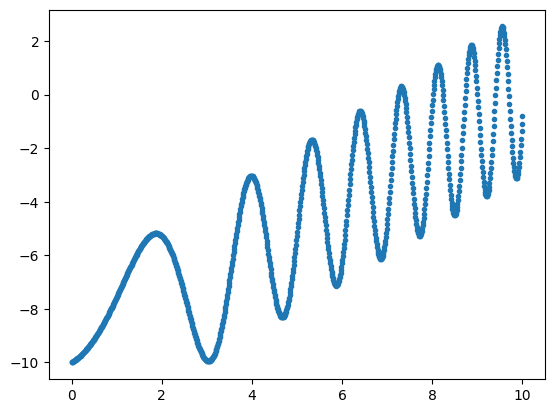

In [4]:
plt.scatter(X, Y, marker='.')
plt.show()

In [5]:
def normalize(X, Y, size: int = 100):
    """
    Min-max normalization.
    """

    x_min, x_max = np.min(X), np.max(X)
    y_min, y_max = np.min(Y), np.max(Y)

    idx = np.round(np.linspace(0, len(X) - 1, size)).astype(int)
    X_norm = ((X - x_min) / (x_max - x_min))[idx]
    Y_norm = ((Y - y_min) / (y_max - y_min))[idx]
    return X_norm, Y_norm

In [6]:
def normalize(X, Y, size: int = 100):
    """
    Z-score normalization (standardization).
    """

    idx = np.round(np.linspace(0, len(X) - 1, size)).astype(int)
    X_norm = X[idx]
    Y_norm = ((Y - np.mean(Y)) / np.std(Y))[idx]
    return X_norm, Y_norm

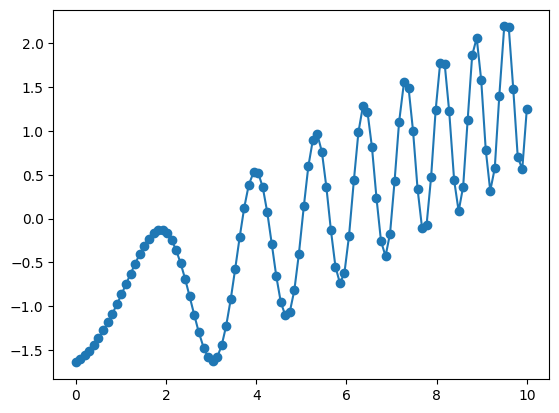

In [7]:
X_norm, Y_norm = normalize(X, Y)
plt.plot(X_norm, Y_norm)
plt.scatter(X_norm, Y_norm)
plt.show()

## Generating the dataset

In [8]:
from symreg.random import random_formula, RandomOptions

- Sinus, cosinus
- Tangent
- Divide, product
- Add, subtract
- Sqrt
- Log

```
  BINARY OPERATORS                   UNARY OPERATORS
 ADD/SUB | MUL/DIV   |   EXP | SIN | TAN | ASIN | ATAN | SQRT | LOG
```

In [9]:
from symreg.formula import ExpressionVisitor, BinaryOp, UnaryOp

class VectorVisitor(ExpressionVisitor):
    def __init__(self):
        super().__init__()
        self.vector = np.zeros(9)

    def visit_binary_expr(self, expr):
        super().visit_binary_expr(expr)

        match expr.op:
            case BinaryOp.ADD | BinaryOp.SUB:
                self.vector[0] = 1
            case BinaryOp.MUL | BinaryOp.DIV:
                self.vector[1] = 1
            case _:
                raise NotImplementedError
    
    def visit_unary_expr(self, expr):
        super().visit_unary_expr(expr)

        match expr.op:
            case UnaryOp.EXP:
                self.vector[2] = 1
            case UnaryOp.SIN:
                self.vector[3] = 1
            case UnaryOp.TAN:
                self.vector[4] = 1
            case UnaryOp.ASIN:
                self.vector[5] = 1
            case UnaryOp.ATAN:
                self.vector[6] = 1
            case UnaryOp.SQRT:
                self.vector[7] = 1
            case UnaryOp.LOG:
                self.vector[8] = 1


def generate_formula_dataset(n: int, sample_count: int = 5, max_depth=3, x_range = (-10, 10)):
    X = np.linspace(x_range[0], x_range[1], sample_count)+1e-5

    options = RandomOptions()
    options.max_depth = max_depth
    options.definition_set = X

    data = []
    labels = []

    i = 0
    while i < n:
        formula = random_formula(options)
        Y = formula(X)

        if isinstance(Y, float):
            Y = np.array([Y] * len(X))

        if np.any(np.isnan(Y)):
            continue

        eta = 1e-3
        Y += eta * np.random.normal(np.mean(Y), np.std(Y), np.shape(Y))

        X_norm, Y_norm = normalize(X, Y, sample_count)
        if np.any(np.isnan(Y_norm)):
            continue

        visitor = VectorVisitor()
        visitor.accept(formula.expr)
        data.append(np.array([X_norm,Y_norm]).T)
        labels.append(visitor.vector)
        i += 1

        if i % 500 == 0:
            print(f"Generated [{i}]")

        if n<=5:

            print(formula)
            plt.plot(X_norm,Y_norm)
            plt.show()

    data = np.array(data)
    labels = np.array(labels)

    data = torch.tensor(data, dtype=torch.float32)
    labels = torch.tensor(labels[:,2:], dtype=torch.float32)

    print(data.shape)
    print(labels.shape)

    return data, labels


atan(x0 * 2.833203155543452 + -3.4867561171115935) * -4.860605088391738 + -0.970927318414395


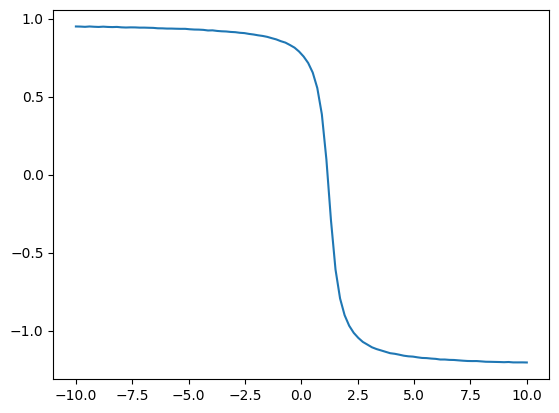

exp(x0 * -1.9418295449540333 + -4.832009730042495) * 4.8602923524628245 + 0.7881342229344988


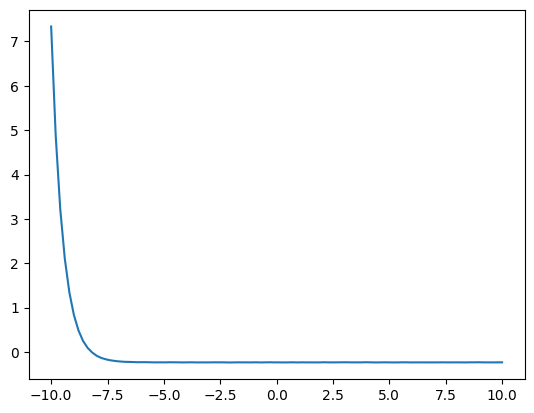

(x0 * 2.698864122925679 + 0.11019911731576038) * (x0 * 0.2963905478537141 + -3.526459800863252)


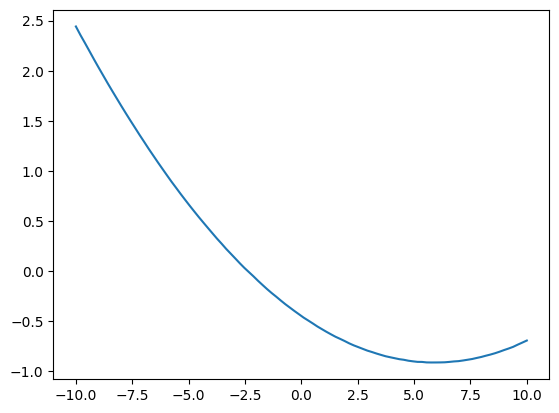

torch.Size([3, 100, 2])
torch.Size([3, 7])


(tensor([[[-1.0000e+01,  9.4908e-01],
          [-9.7980e+00,  9.4846e-01],
          [-9.5959e+00,  9.4681e-01],
          [-9.3939e+00,  9.4907e-01],
          [-9.1919e+00,  9.4724e-01],
          [-8.9899e+00,  9.4609e-01],
          [-8.7879e+00,  9.4792e-01],
          [-8.5858e+00,  9.4612e-01],
          [-8.3838e+00,  9.4521e-01],
          [-8.1818e+00,  9.4622e-01],
          [-7.9798e+00,  9.4358e-01],
          [-7.7778e+00,  9.4244e-01],
          [-7.5757e+00,  9.4340e-01],
          [-7.3737e+00,  9.4309e-01],
          [-7.1717e+00,  9.4166e-01],
          [-6.9697e+00,  9.4176e-01],
          [-6.7677e+00,  9.4082e-01],
          [-6.5656e+00,  9.4005e-01],
          [-6.3636e+00,  9.3748e-01],
          [-6.1616e+00,  9.3707e-01],
          [-5.9596e+00,  9.3562e-01],
          [-5.7576e+00,  9.3559e-01],
          [-5.5555e+00,  9.3464e-01],
          [-5.3535e+00,  9.3399e-01],
          [-5.1515e+00,  9.3402e-01],
          [-4.9495e+00,  9.3124e-01],
          [-

In [10]:
generate_formula_dataset(3,100, 4)

## Training

In [11]:
INPUT_SAMPLES = 100
OUTPUT_FEATURES = 7
THRESHOLD = 0.5
MAX_DEPTH = 4

In [12]:
n_train = 20000
n_test = 1000
train_data, train_labels = generate_formula_dataset(n_train, INPUT_SAMPLES, MAX_DEPTH)
dataset = TensorDataset(train_data, train_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
test_data, train_labels = generate_formula_dataset(n_test, INPUT_SAMPLES, MAX_DEPTH)
datatest = TensorDataset(test_data, train_labels)
testloader = DataLoader(datatest, batch_size=32, shuffle=True)

c:\Users\nboye\Documents\projects\MLP-SymReg\symreg\formula.py:351: RuntimeWarning: overflow encountered in exp
  return self.op.value(operand)
c:\Users\nboye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Generated [500]


c:\Users\nboye\Documents\projects\MLP-SymReg\symreg\formula.py:237: RuntimeWarning: overflow encountered in multiply
  return self.op.value(lhs, rhs)
c:\Users\nboye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\nboye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:173: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Generated [1000]


c:\Users\nboye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Generated [1500]
Generated [2000]
Generated [2500]
Generated [3000]
Generated [3500]
Generated [4000]
Generated [4500]
Generated [5000]


c:\Users\nboye\Documents\projects\MLP-SymReg\symreg\simplify.py:148: RuntimeWarning: overflow encountered in exp
  return ConstantExpression(expr.op.value(expr.operand.value))


Generated [5500]
Generated [6000]
Generated [6500]
Generated [7000]
Generated [7500]
Generated [8000]
Generated [8500]
Generated [9000]
Generated [9500]
Generated [10000]
Generated [10500]
Generated [11000]
Generated [11500]
Generated [12000]


C:\Users\nboye\AppData\Local\Temp\ipykernel_24000\1416907520.py:8: RuntimeWarning: invalid value encountered in divide
  Y_norm = ((Y - np.mean(Y)) / np.std(Y))[idx]


Generated [12500]
Generated [13000]
Generated [13500]
Generated [14000]
Generated [14500]
Generated [15000]
Generated [15500]
Generated [16000]
Generated [16500]
Generated [17000]
Generated [17500]
Generated [18000]
Generated [18500]
Generated [19000]
Generated [19500]
Generated [20000]
torch.Size([20000, 100, 2])
torch.Size([20000, 7])
Generated [500]
Generated [1000]
torch.Size([1000, 100, 2])
torch.Size([1000, 7])


tensor([1., 0., 1., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 1., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 1., 1., 0.])
tensor([0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 1., 0., 0.])


C:\Users\nboye\AppData\Local\Temp\ipykernel_24000\3809423843.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


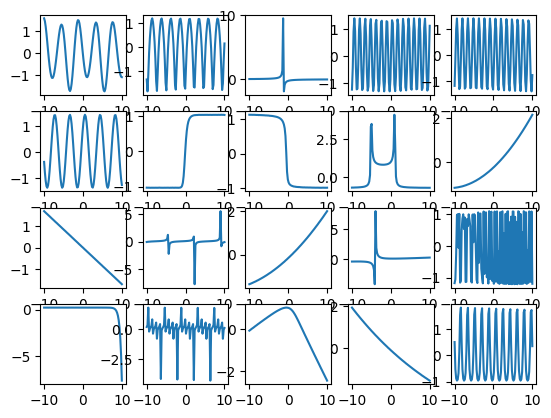

In [13]:
WIDTH, HEIGHT = 5, 4
f, ax = plt.subplots(HEIGHT, WIDTH)
for i in range(HEIGHT):
    for j in range(WIDTH):
        idx = j * HEIGHT + i
        ax[i][j].plot(train_data[idx,:,0], train_data[idx,:,1])
        print(train_labels[idx])
f.show()

In [14]:
def train_model(model, dataloader, epochs):
  model.to(device)
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
  loss_fn = nn.MSELoss()

  for epoch in range(epochs):
    running_loss, running_acc = 0.0, 0
    i=0
    nans = 0
    local_n_train = n_train
    for _, data in enumerate(dataloader):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      if torch.isnan(loss):
        local_n_train-=len(inputs)
        nans += 1
        i+=1
        continue
      loss.backward()
      optimizer.step()

      preds = (outputs >= THRESHOLD)
      running_acc += torch.sum(preds == labels).item()
      running_loss += loss.item()
      i+=1

      if torch.isnan(outputs[0][0]):print("Un output est nan")

    print(f"[TRAIN epoch {epoch}]: Loss: {running_loss/local_n_train} Accuracy: {running_acc/local_n_train/OUTPUT_FEATURES}, NANs dodged: {nans}")

In [15]:
def test_model(model, dataloader):
  model.to(device)
  model.eval()

  local_n_train = n_test

  running_acc = 0.0
  with torch.no_grad():
    for _, data in enumerate(dataloader):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)

      preds = (outputs >= THRESHOLD)
      running_acc += torch.sum(preds == labels).item()

  if local_n_train==0:print("Plus rien ne va")

  print(f"[TEST]: Accuracy: {running_acc/local_n_train/OUTPUT_FEATURES}")

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * INPUT_SAMPLES, 128)  # 100 is the dimension after conv layers
        self.fc2 = nn.Linear(128, OUTPUT_FEATURES)
        
    def forward(self, x):
        # Input shape: [batch_size, 100, 2]
        
        # Transpose to [batch_size, 2, 100] for Conv1D (since PyTorch expects [batch_size, channels, length])
        x = x.transpose(1, 2)
        
        # Convolutional layers + activation
        x = F.relu(self.conv1(x))
        
        # Flatten
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        # Fully connected layers + activation
        x = F.relu(self.fc1(x))
        
        # Output layer
        x = self.fc2(x)
        
        return x

In [17]:
model = CNN()
train_model(model, dataloader, 10)
test_model(model, testloader)

[TRAIN epoch 0]: Loss: 0.0032414007011801003 Accuracy: 0.8643285714285714, NANs dodged: 0
[TRAIN epoch 1]: Loss: 0.0026436730291694403 Accuracy: 0.8958785714285714, NANs dodged: 0
[TRAIN epoch 2]: Loss: 0.0024522794298827647 Accuracy: 0.9062214285714285, NANs dodged: 0
[TRAIN epoch 3]: Loss: 0.0023490069070830942 Accuracy: 0.9094357142857143, NANs dodged: 0
[TRAIN epoch 4]: Loss: 0.0022893494475632907 Accuracy: 0.9107071428571428, NANs dodged: 0
[TRAIN epoch 5]: Loss: 0.002250502383802086 Accuracy: 0.9113642857142857, NANs dodged: 0
[TRAIN epoch 6]: Loss: 0.0022134133147075773 Accuracy: 0.9127428571428571, NANs dodged: 0
[TRAIN epoch 7]: Loss: 0.0021864639151841403 Accuracy: 0.9136, NANs dodged: 0
[TRAIN epoch 8]: Loss: 0.0021640251871198417 Accuracy: 0.9139928571428572, NANs dodged: 0
[TRAIN epoch 9]: Loss: 0.0021317995519377292 Accuracy: 0.9148, NANs dodged: 0
[TEST]: Accuracy: 0.9162857142857143


In [18]:
def predict(formula):
    X = np.linspace(-10, 10, INPUT_SAMPLES)
    visitor = VectorVisitor()
    visitor.accept(formula.expr)
    Y = formula(X)
    X_norm, Y_norm = normalize(X, Y, INPUT_SAMPLES)
    Y_norm = torch.tensor(np.array([X_norm,Y_norm]).T, dtype=torch.float32).unsqueeze(0)
    preds = model(Y_norm) >= THRESHOLD
    return preds

In [19]:
print(predict(Formula(UnaryExpression(UnaryOp.SIN, VariableExpression("x")))))
print(predict(Formula(UnaryExpression(UnaryOp.LOG, VariableExpression("x")))))
print(predict(Formula(UnaryExpression(UnaryOp.EXP, VariableExpression("x")))))
print(predict(Formula(UnaryExpression(UnaryOp.SQRT, VariableExpression("x")))))

TypeError: '<' not supported between instances of 'str' and 'int'

((sin(x0 * -0.48753344892829453 + -1.4314184111536745) * -1.5936725250040618 + -4.070893852508379) * -4.250289115592843) * (sin(sin(x0 * -1.6802770086218777 + -0.16817816679111708) * -1.3451208358639786 + -1.9902477272123331) * 2.368614979555855 + -1.4595168095135613)
[0. 1. 0. 0. 0. 0. 0.]
tensor([[0.1620, 1.0248, 0.1292, 0.0167, 0.2387, 0.0489, 0.0252]],
       grad_fn=<AddmmBackward0>)
tensor([[False,  True, False, False, False, False, False]])
tensor(1.)


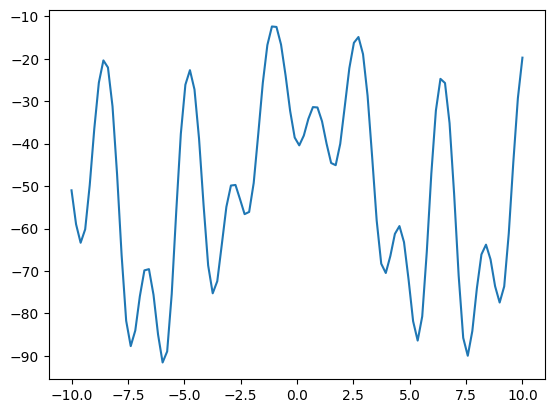

In [23]:
import torch.types


X = np.linspace(-10, 10, INPUT_SAMPLES)
options = RandomOptions()
options.max_depth = MAX_DEPTH
options.definition_set = X

formula = random_formula(options)
visitor = VectorVisitor()
visitor.accept(formula.expr)
print(formula)
print(visitor.vector[2:])

Y = formula(X)

X_norm, Y_norm = normalize(X, Y, INPUT_SAMPLES)
Y_norm = torch.tensor(np.array([X_norm,Y_norm]).T, dtype=torch.float32).unsqueeze(0)
print(model(Y_norm))

preds = model(Y_norm) >= THRESHOLD
print(preds)
print(torch.sum(preds == visitor.vector[2:]) / OUTPUT_FEATURES)

plt.plot(X, Y)
plt.show()